In [1]:
# !pip install torch

In [19]:
# Data Analysis
import pandas as pd
import numpy as np

# Data Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Metrics (distance) and stats
from scipy.spatial.distance import euclidean
from scipy.stats import median_abs_deviation

# Unsupervised (Machine) Learning
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#ANN
import torch
import torch.nn as nn
import torch.optim as optim

# save data
import pickle

In [20]:
# Helper function
def reduce_mem_usage(df):
    """
        to reduce memory.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [21]:
# loading train_transaction data
train_transaction = pd.read_csv('./ieee-fraud-detection/train_transaction.csv')

In [22]:
train_transaction.dtypes

TransactionID       int64
isFraud             int64
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
                   ...   
V335              float64
V336              float64
V337              float64
V338              float64
V339              float64
Length: 394, dtype: object

In [23]:
train_transaction = reduce_mem_usage(train_transaction)
train_transaction.head()

Memory usage of dataframe is 1775.15 MB
Memory usage after optimization is: 487.16 MB
Decreased by 72.6%


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
# Loading train_identity data
train_identity = pd.read_csv('./ieee-fraud-detection/train_identity.csv')
train_identity = reduce_mem_usage(train_identity)
train_identity.head()

Memory usage of dataframe is 45.12 MB
Memory usage after optimization is: 10.00 MB
Decreased by 77.8%


,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [25]:
# Merging transaction and identity train data
train_df = pd.merge(train_transaction, train_identity, how='left')
print(train_df.shape)
len_train_df = len(train_df)
del train_transaction, train_identity

(590540, 434)


In [26]:
# Loading test data
test_transaction = pd.read_csv('./ieee-fraud-detection/test_transaction.csv')
print(test_transaction.shape)
test_transaction = reduce_mem_usage(test_transaction)

test_identity = pd.read_csv('./ieee-fraud-detection/test_identity.csv')
test_identity = reduce_mem_usage(test_identity)

test_df = pd.merge(test_transaction, test_identity, how='left')
test_df.columns = train_df.drop('isFraud', axis=1).columns
del test_transaction, test_identity
test_df.head()

(506691, 393)
Memory usage of dataframe is 1519.24 MB
Memory usage after optimization is: 425.24 MB
Decreased by 72.0%
Memory usage of dataframe is 44.39 MB
Memory usage after optimization is: 9.84 MB
Decreased by 77.8%


,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.953125,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000000,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.000000,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,285.000000,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.937500,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


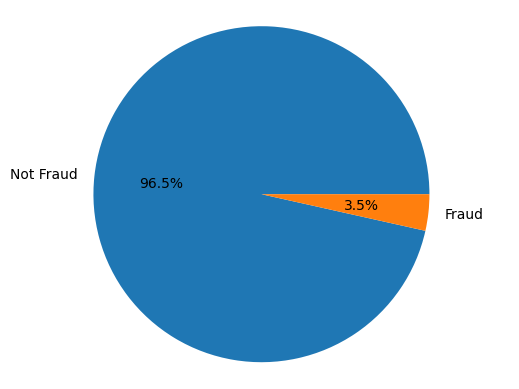

In [27]:
# Class imbalance check
plt.pie(train_df.isFraud.value_counts(), labels=['Not Fraud', 'Fraud'], autopct='%0.1f%%')
plt.axis('equal')
plt.show()

In [28]:
# Missing values check
combined_df = pd.concat([train_df.drop(columns=['isFraud', 'TransactionID']), test_df.drop(columns='TransactionID')])
# Dependent variable
y = train_df['isFraud']

# Dropping columns with more than 20% missing values 
mv = combined_df.isnull().sum()/len(combined_df)
combined_mv_df = combined_df.drop(columns=mv[mv>0.2].index)
del combined_df, train_df, test_df

In [29]:
# Filtering numerical data
num_mv_df = combined_mv_df.select_dtypes(include=np.number)
# Filtering categorical data
cat_mv_df = combined_mv_df.select_dtypes(exclude=np.number)
del combined_mv_df

In [30]:
# Filling missing values by median for numerical columns 
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
num_df = pd.DataFrame(imp_median.fit_transform(num_mv_df), columns=num_mv_df.columns)
del num_mv_df

In [31]:
# Filling missing values by most frequent value for categorical columns
imp_max = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
cat_df = pd.DataFrame(imp_max.fit_transform(cat_mv_df), columns=cat_mv_df.columns)
del cat_mv_df

In [32]:
# Concatinating numerical and categorical data
combined_df_cleaned = pd.concat([num_df, cat_df], axis=1)
del num_df, cat_df

# Verifying missing values
print(f'Total missing values: {combined_df_cleaned.isnull().sum().sum()}')
combined_df_cleaned.head()

Total missing values: 0


,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,...,V316,V317,V318,V319,V320,V321,ProductCD,card4,card6,P_emaildomain
0,86400.0,68.5,13926.0,361.0,150.0,142.0,315.0,87.0,1.0,1.0,...,0.0,117.0,0.0,0.0,0.0,0.0,W,discover,credit,gmail.com
1,86401.0,29.0,2755.0,404.0,150.0,102.0,325.0,87.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,W,mastercard,credit,gmail.com
2,86469.0,59.0,4663.0,490.0,150.0,166.0,330.0,87.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,W,visa,debit,outlook.com
3,86499.0,50.0,18132.0,567.0,150.0,117.0,476.0,87.0,2.0,5.0,...,50.0,1404.0,790.0,0.0,0.0,0.0,W,mastercard,debit,yahoo.com
4,86506.0,50.0,4497.0,514.0,150.0,102.0,420.0,87.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,H,mastercard,credit,gmail.com


In [33]:
# One-hot encoding
combined_df_encoded = pd.get_dummies(combined_df_cleaned, drop_first=True)
del combined_df_cleaned
combined_df_encoded.head()

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,...,P_emaildomain_web.de,P_emaildomain_windstream.net,P_emaildomain_yahoo.co.jp,P_emaildomain_yahoo.co.uk,P_emaildomain_yahoo.com,P_emaildomain_yahoo.com.mx,P_emaildomain_yahoo.de,P_emaildomain_yahoo.es,P_emaildomain_yahoo.fr,P_emaildomain_ymail.com
0,86400.0,68.5,13926.0,361.0,150.0,142.0,315.0,87.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,86401.0,29.0,2755.0,404.0,150.0,102.0,325.0,87.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,86469.0,59.0,4663.0,490.0,150.0,166.0,330.0,87.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,86499.0,50.0,18132.0,567.0,150.0,117.0,476.0,87.0,2.0,5.0,...,0,0,0,0,1,0,0,0,0,0
4,86506.0,50.0,4497.0,514.0,150.0,102.0,420.0,87.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
# Separating train and test data
X = combined_df_encoded.iloc[:len_train_df]
test = combined_df_encoded.iloc[len_train_df:]
del combined_df_encoded

In [35]:
# Time-based train validation splitting with 20% data in validation set
train = pd.concat([X, y], axis=1)
train.sort_values('TransactionDT', inplace=True)
X = train.drop(['isFraud'], axis=1)
y = train['isFraud']
splitting_index = int(0.8*len(X))
X_train = X.iloc[:splitting_index].values
X_val = X.iloc[splitting_index:].values
y_train = y.iloc[:splitting_index].values
y_val = y.iloc[splitting_index:].values
test = test.values
del y, train

In [36]:
# Scaler data: Min-Max Scaling
# dữ liệu nằm trong khoảng giá trị cụ thể: [0, 1]
# X_scaled = (X - X_min) / (X_max - X_min)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
test_scaled = scaler.transform(test)
del X_train, X_val, test

### save data

In [19]:
# Lưu dữ liệu vào file
with open('./ieee-fraud-detection-lite/train-scaled.pickle', 'wb') as f:
    pickle.dump(X_train_scaled, f)

with open('./ieee-fraud-detection-lite/label-train-scaled.pickle', 'wb') as f:
    pickle.dump(y_train, f)

with open('./ieee-fraud-detection-lite/val-scaled.pickle', 'wb') as f:
    pickle.dump(X_val_scaled, f)

with open('./ieee-fraud-detection-lite/label-val-scaled.pickle', 'wb') as f:
    pickle.dump(y_val, f)